In [151]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import scipy

samples, sr = librosa.load('audio_examples/voice.wav', sr=44100)
samples = samples[sr: 3 * sr] # two seconds only and dial down the volume a bit

def unit_impulse(N):
    impulse = np.zeros(N)
    impulse[0] = 1
    return impulse

# **FIR Filters**

**Note:**: This notebook is not complete and needs more research. Look into book *Digital Audio Processing** by U. Zolzer.

The digital filters discussed so far are known as **infinite impulse response (IIR)** filters. Due to the feedback loops within their structure, a single input sample can produce an output signal that lasts for an extended period, depending on the filter's tuning parameters.


In contrast, **finite impulse response (FIR) filters** do not have feedback loops. The response of an FIR filter to a unit impulse lasts only for a fixed period. These filters are ideal for designing systems that require strong attenuation of unwanted frequencies or decomposing a signal into several frequency bands.

**Example FIR filter**

<img src="diagrams/fir_filter_example.png" width="70%">


### **Applications of FIR Filters**

FIR filters typically require higher-order designs to achieve similar results as IIR filters, which translates into higher computational costs. However, when FIR filters are implemented using **fast convolution techniques** (such as the **FFT algorithm**), they become much more computationally efficient and competitive with IIR filters. 

Despite these optimizations, FIR filters can be less practical in real-time, interactive applications due to the difficulty of tuning them dynamically. For example, in a vocoder application:
- If the frequency bands are **fixed**, an FIR implementation is very effective.
- If the frequency bands need to be **subtly tuned in real-time** by a performer, an IIR structure would likely perform better due to its more flexible, low-order design.

That said, FIR filters find widespread use in applications such as **head-related transfer functions (HRTFs)** and the approximation of **room reflections**. In cases where the impulse response of a real system (such as a room or device) has been measured, FIR filters are ideal for directly simulating that measured response.

### **Signal Processing**

The output of the FIR filter, as shown in the diagram, is described by the difference **equation**:

$$
\large
y(n) = \sum\limits_{i=0}^{N-1}b_i \cdot x(n - i)
\large
$$
<br>

This expands to:

$$
\large
y(n) = b_0 x(n) + b_1 x(n - 1) + \dots + b_{N-1} x(n - N + 1)
\large
$$
<br>

It represents the **weighted sum of delayed input samples**. If the input signal is a unit impulse  $\delta(n)$, which equals 1 at  $n = 0$  and 0 otherwise, the output becomes the filter's **impulse response**:

$$
\large
h(n) = \sum\limits_{i=0}^{N-1} b_i \cdot \delta(n - i) = b_n
\large
$$
<br>

$h(n) = b_n$ because the impulse response takes the value of the filter coefficients when the input is an impulse, as each delayed sample only "activates" the corresponding filter coefficient.

To compute the **transfer function**, apply the Z-transform to the impulse response:

$$
\large
H(z) = \sum\limits_{i=0}^{N-1} b_i \cdot z^{-i}
\large
$$
<br>

For the frequency response, substitute  $z = e^{j \omega}$ :

$$
\large
H(e^{j \omega}) = b_0 + b_1 \cdot e^{-j \omega} + b_2 \cdot e^{-j 2 \omega} + ... + \dots + b_{N-1} \cdot e^{-j(N-1)\omega}
\large
$$

with 
$$
\omega= \frac{2 \cdot \pi f}{f_s}
$$

<br>
Below an example vizualation of a FIR filter impulse response.

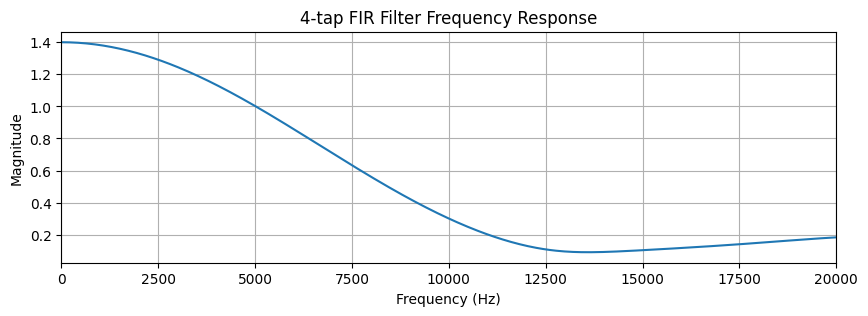

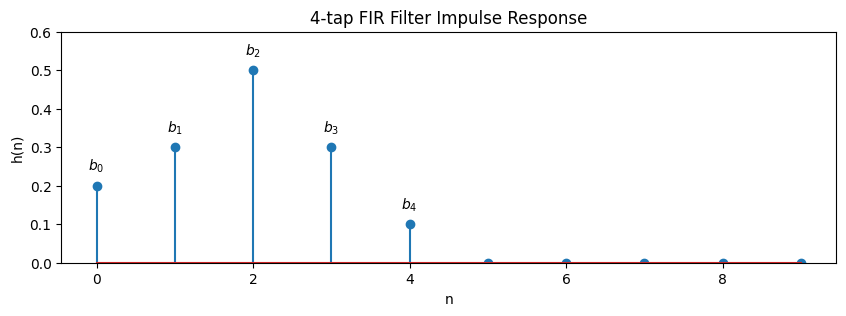

In [152]:
def fir_filter(x,bs):
    N = len(bs)
    y = np.zeros(len(x))

    for n in range(len(x)):
        for i in range(N):
            if n - i >= 0:  
              y[n] += bs[i] * x[n - i]
                
    return y

def fir_freq_response(bs, fs, n_points=512):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    N = len(bs)

    for n, omega in enumerate(w):
        z = np.exp(1j * omega)
        H[n] = bs[0]

        for i in range(1, N):
            H[n] += bs[i] * z**(-i)

    freqs = (w * fs) / (2 * np.pi)  

    return freqs, w, H

N = 10
bs = [0.2, 0.3, 0.5, 0.3, 0.1] # made up coeffs for example
fs = 44100

impulse = unit_impulse(N) 
imp_response = fir_filter(impulse, bs)

freqs, w, H = fir_freq_response(bs, fs)

plt.figure(figsize=(10, 3))
plt.plot(freqs, np.abs(H))
plt.title("4-tap FIR Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 20000)
plt.grid(True)

plt.figure(figsize=(10, 3))
plt.stem(np.arange(len(imp_response)), imp_response)
plt.ylabel("h(n)")
plt.xlabel("n")
plt.ylim(0, 0.6)
plt.title("4-tap FIR Filter Impulse Response")

for i in range(len(bs)):
    plt.text(i, imp_response[i] + 0.04, "$%s$" % f"b_{i}", ha='center')


plt.show()

## **FIR Filter Design**

The types of filters we explored with IIR filters, such as lowpass, highpass, bandpass, and bandreject, can also be implemented using FIR filter structures. The $N$ coefficients $b_0, b_1, \dots, b_{N-1}$ of an FIR filter must be computed using **filter design algorithms** or tools, which are covered in most DSP textbooks. These coefficients define the filter's impulse response. When certain **symmetry conditions** are met, the FIR filter can have a **linear phase response**.

### **Windowed-Sinc FIR Filter Design**

One simple design method is based on the inverse discrete-time Fourier transform (DTFT) of an ideal lowpass filter. This results in the following impulse response:

$$
\large
h(n) = \frac{2 \cdot f_c}{f_s} \cdot \frac{\sin\left[2\pi \cdot \frac{f_c}{f_s} \cdot \left(n - \frac{N - 1}{2}\right)\right]}{2\pi \cdot \frac{f_c}{f_s} \cdot \left(n - \frac{N-1}{2}\right)}
\large
$$

where $n = 0, \dots, N-1$.

For **frequency response** we compute the DTFT of the impulse reponse at at discrite frequencies of the range of $\omega$ (from 0 to $\pi$).

$$
\large
H(\epsilon^{j \omega}) = \sum\limits_{n=0}^{N-1} h[n] \cdot \epsilon^{-j \omega n}
\large
$$
<br>

To improve the frequency response, a **window function** like Hamming or Blackman is applied to the impulse response:

$$
\large
h_b(n) = h(n) \cdot w_b(n)
\large
$$
<br>

where $w_b(n)$ is the window function. This reduces ripples in the frequency response, leading to a more practical filter.

#### **Frequency Transformations**

0nce the lowpass filter is designed, it can be transformed into highpass, bandpass, and bandreject filters by modifying the impulse response.

**LPF → HPF**

$$
\large
h_{hp}(n) =h_{lp}(n) \cdot cos[\pi( n - \frac{N -1}{2})]
\large
$$

**LPF → BPF**

$$
\large
h_{hp}(n) = 2 \cdot h_{lp}(n) \cdot cos[2\pi \frac{f_c}{f_s}( n - \frac{N -1}{2})]
\large
$$

**LPF → BRF**

$$
\large
h_{br} = \delta(n - \frac{N -1}{2}) - h_{bp}(n)
\large
$$
<br>


#### **Example Implementation:** FIR LPF

Unlike the IIR filters we've previously explored, where the filtered signal is computed using a **difference equation**, FIR filters begin with the **impulse response** of the system. As shown in the vizualiation above, the impulse response for an FIR filter is the same as its filter coefficients.

To apply the filter, we use **convolution** rather than a difference equation. Convolution directly computes the output by applying the filter's coefficients to the input signal. Additionally, we apply a **window function** to the impulse response to improve the frequency response, as mentioned earlier.

The window function helps prevent the ripples in the frequency response, though they are still visible in the plot. Increasing the taps ($N$) may improve this.

Note that **normalization** of $h(n)$ may be applied to ensure the **unity gain** at DC. This normalization is ommited in this implementation.

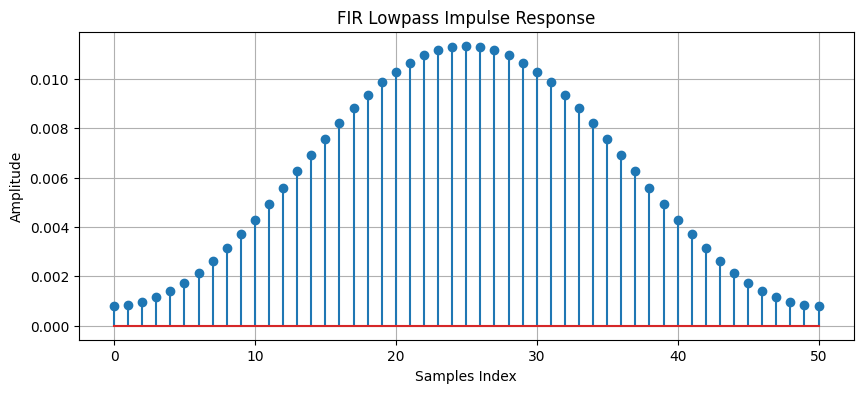

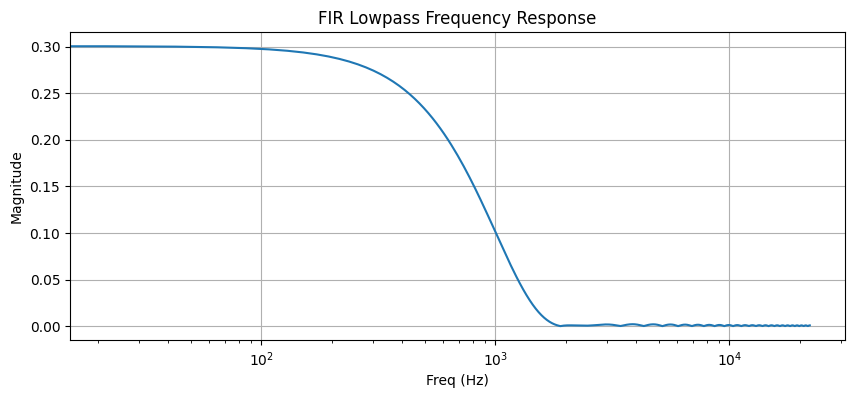

Filtered Sigal


In [211]:
fs = sr
fc = 250
N  = 51 # number of filter taps


def window_sinc_lpf_impulse(N, fc, fs):
    n = np.arange(N)
    center = (N - 1) / 2
    x = 2 * fc / fs * (n - center)
    h_lpf = (2 * fc / fs) * np.sinc(x)
    return h_lpf


def window_sinc_freq_response(h, n_points = 1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    N = len(h)

    # basically calculating the DFT
    for i, omega in enumerate(w):
        for n in range(N):
            H[i] += h[n] * np.exp(-1j * omega * n)

    freqs = (w * fs) / (2 * np.pi)

    return freqs, w, H


h_lpf = window_sinc_lpf_impulse(N, fc, fs)

window = np.hamming(N)
h_lpf = h_lpf * window

filtered = scipy.signal.convolve(samples, h_lpf)
freqs, w, H = window_sinc_freq_response(h_lpf)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(N), h_lpf)
plt.title("FIR Lowpass Impulse Response")
plt.xlabel("Samples Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.figure(figsize=(10, 4))
plt.title("FIR Lowpass Frequency Response")
plt.plot(freqs, np.abs(H) ) 
plt.ylabel("Magnitude")
plt.xlabel("Freq (Hz)")
plt.xscale('log')
plt.grid(True)


plt.show()
print("Filtered Sigal")
display(Audio(filtered, rate=fs))


#### **Example Implementation**: Derived FIR HPF, BPF and BRF

Using the LPF impulse response above and **frequency transformations** , we impulse responses for the counterpart filter LPF, BPF, BRF.

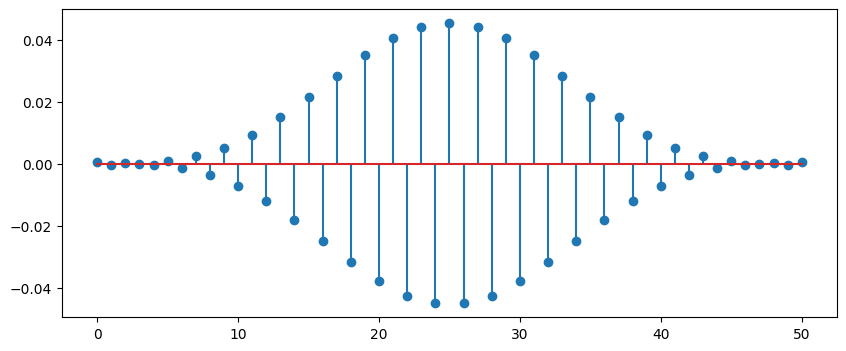

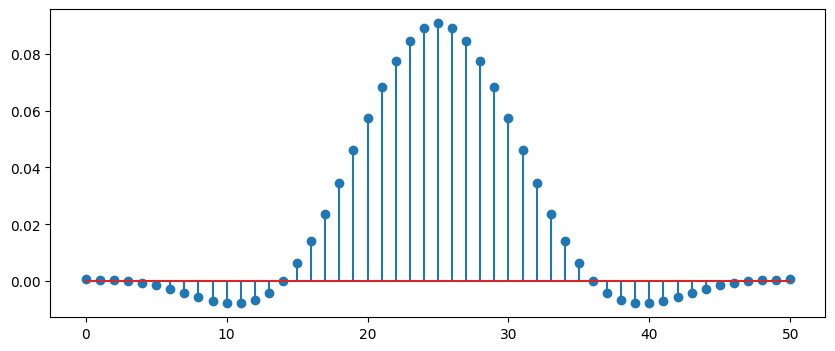

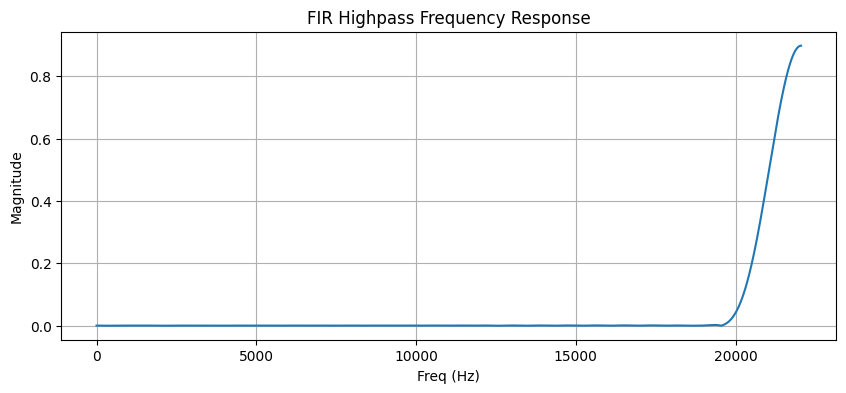

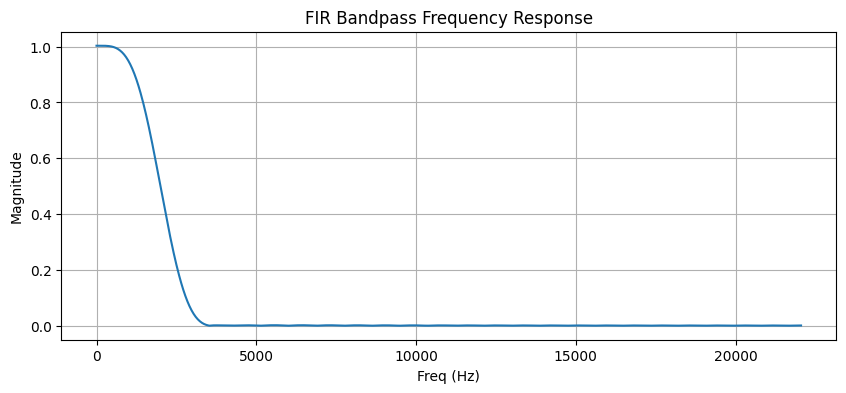

In [222]:
def lpf_to_hpf(h_lpf):
    N = len(h_lpf)
    n = np.arange(N)
    h_hpf = h_lpf * np.cos(np.pi * (n - (N - 1) / 2))
    return h_hpf


    return h_hpf

# def lpf_to_hpf(h_lpf):
#     N = len(h_lpf)
#     delta = np.zeros(N)
#     center = (N - 1) // 2
#     delta[center] = 1
#     h_hpf = delta - h_lpf
#     return h_hpf

# N = len(h_lpf)
#    n = np.arange(N)
#    h_hpf = h_lpf * np.cos(np.pi * (n - (N - 1) / 2))
#    return h_hpf
#

#def lpf_to_bpf(h_lpf, fc, fs):
#     N = len(h_lpf)
#     h_bpf = np.zeros_like(h_lpf)
# 
#     for n in range(N):
#         h_bpf[n]= 2 * h_lpf[n] * np.cos(2 * np.pi * fc/fs * (n - (N - 1) / 2))
# 
#     return h_bpf
       

# changing the fc and recalculating the LPF so HPF and BPF are more noticable
fc = 1000
h_lpf = window_sinc_lpf_impulse(N, fc, fs)
h_lpf = h_lpf * window

h_hpf = lpf_to_hpf(h_lpf)
h_bpf = lpf_to_bpf(h_lpf, fc, fs)


filtered_highpass = scipy.signal.convolve(samples, h_hpf)
filtered_bandpass = scipy.signal.convolve(samples, h_bpf)
freqs, w, H_hpf = window_sinc_freq_response(h_hpf)
_, _, H_bpf = window_sinc_freq_response(h_bpf)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(h_hpf)), h_hpf)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(h_bpf)), h_bpf)

plt.figure(figsize=(10, 4))
plt.title("FIR Highpass Frequency Response")
plt.plot(freqs, np.abs(H_hpf) ) 
plt.ylabel("Magnitude")
plt.xlabel("Freq (Hz)")
plt.grid(True)


plt.figure(figsize=(10, 4))
plt.title("FIR Bandpass Frequency Response")
plt.plot(freqs, np.abs(H_bpf) ) 
plt.ylabel("Magnitude")
plt.xlabel("Freq (Hz)")
plt.grid(True)


plt.show()


display(Audio(filtered_highpass, rate=sr))
display(Audio(filtered_bandpass, rate=sr))
    